# Image Caption Generator

In [2]:
import string 
import os
from PIL import Image
import numpy as np
from pickle import dump, load
import tensorflow as tf
from tqdm import tqdm 

2024-06-29 22:14:48.468425: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 22:14:48.802036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 22:14:49.484791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### functions for making clean description file from the dataset


In [5]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img_cap = caption.split('#')
        if img_cap[0] not in descriptions:
            descriptions[img_cap[0]] = [ img_cap[1][2:] ]
        else:
            descriptions[img_cap[0]].append(img_cap[-1][2:] )
    return descriptions

#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


# build vocabulary of all unique words
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab


def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()



### Run if `description.txt` donot exits


In [7]:
 

# filename = "./" + "Flickr8k.token.txt"

# descriptions = all_img_captions(filename=filename)
# print("Length of descriptions =" ,len(descriptions))

# clean_descriptions = cleaning_text(descriptions)
# vocabulary = text_vocabulary(clean_descriptions)
# print("Length of vocabulary = ", len(vocabulary))
# save_descriptions(clean_descriptions, "./descriptions.txt")



Length of descriptions = 8092
Length of vocabulary =  8763


## Extracting features from the dataset and storing in the `features.p` pickle file
#### Run if file not exists

In [ ]:
def extract_features(directory):
        model = tf.keras.applications.xception.Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features

features = extract_features("./Flicker8k_Dataset")
dump(features, open("features.p","wb"))


In [8]:
features = load(open("features.p","rb"))


def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features



filename = "./" + "Flickr_8k.trainImages.txt"


train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)




In [20]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tok    enizer.p', 'wb'))

vocab_size = len(tokenizer.word_index) + 1
vocab_size




7577

In [34]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)


max_length = max_length(descriptions)
max_length

32

In [170]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            for i in range(len(input_image)):
                yield (tf.convert_to_tensor(input_image[i]), tf.convert_to_tensor(input_sequence[i])),tf.convert_to_tensor( output_word[i])

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model


In [171]:
def cnn_model(vocab_size,max_length):
    inputs1 = tf.keras.layers.Input(shape=(2048,))
    img_layer1 = tf.keras.layers.Dropout(0.5)(inputs1)
    img_layer2 = tf.keras.layers.Dense(256,activation="relu")(img_layer1)

    inputs2 = tf.keras.layers.Input(shape=(max_length,))
    cap_layer1 = tf.keras.layers.Embedding(vocab_size,256,mask_zero=True)(inputs2)
    cap_layer2 = tf.keras.layers.Dropout(0.5)(cap_layer1)
    cap_layer3 = tf.keras.layers.LSTM(256)(cap_layer2)

    decoder1 = tf.keras.layers.Add()([img_layer2,cap_layer3])
    decoder2 = tf.keras.layers.Dense(256,activation="relu")(decoder1)
    outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)

    model = tf.keras.models.Model(inputs=(inputs1, inputs2), outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    # plot_model(model, to_file='./model.png', show_shapes=True)

    return model


model = cnn_model(vocab_size, max_length)





Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_67      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_66      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_33        │ (None, 32, 256)   │  1,939,712 │ input_layer_67[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 2048)      │          0 │ input_layer_66[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 32, 256)   │          0 │ embedding_33[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_33        │ (None, 32)        │          0 │ input_layer_67[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 256)       │    524,544 │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 256)       │    525,312 │ dropout_67[0][0], │
│                     │                   │            │ not_equal_33[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 256)       │          0 │ dense_91[0][0],   │
│                     │                   │            │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 256)       │     65,792 │ add_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 7577)      │  1,947,289 │ dense_92[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,002,649 (19.08 MB)

 Trainable params: 5,002,649 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

None


In [173]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

epochs = 10
steps = len(train_descriptions)


def dataset_generator():
    return data_generator(train_descriptions, train_features, tokenizer, max_length)



output_signature = (
    (tf.TensorSpec(shape=(2048,), dtype=tf.float32),
     tf.TensorSpec(shape=(max_length,), dtype=tf.int32)),
    tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    dataset_generator,
    output_signature=output_signature
).batch(32)

# print(generator)




for i in tqdm(range(epochs)):
    model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")



Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


  0%|          | 0/10 [00:00<?, ?it/s]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 385s 64ms/step - loss: 3.8582


 10%|█         | 1/10 [06:24<57:44, 384.95s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 396s 66ms/step - loss: 3.5088


 20%|██        | 2/10 [13:01<52:12, 391.60s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 396s 66ms/step - loss: 3.2926


 30%|███       | 3/10 [19:37<45:56, 393.72s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 398s 66ms/step - loss: 3.1467


 40%|████      | 4/10 [26:15<39:32, 395.36s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 400s 67ms/step - loss: 3.0413


 50%|█████     | 5/10 [32:54<33:04, 396.89s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 396s 66ms/step - loss: 2.9600


 60%|██████    | 6/10 [39:31<26:26, 396.65s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 405s 67ms/step - loss: 2.8930


 70%|███████   | 7/10 [46:16<19:58, 399.40s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 405s 67ms/step - loss: 2.8394


 80%|████████  | 8/10 [53:01<13:22, 401.17s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 405s 67ms/step - loss: 2.7891


 90%|█████████ | 9/10 [59:45<06:42, 402.27s/it]

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 404s 67ms/step - loss: 2.7461


100%|██████████| 10/10 [1:06:29<00:00, 398.94s/it]


In [190]:
model.save("models/model" + ".keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step



start group of people are standing on rocks with the sun in the background end


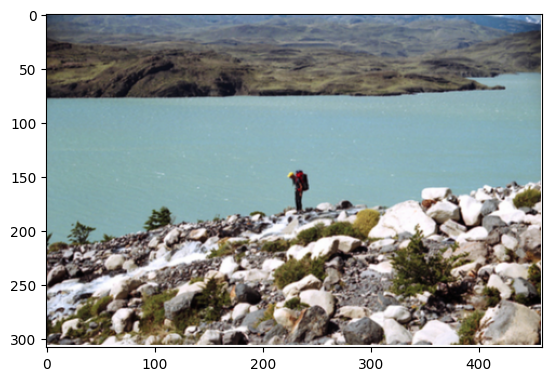

In [195]:
import argparse
import matplotlib.pyplot as plt




# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())
img_path = "./t3.png"

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
# model = tf.keras.models.load_model('models/model_9.h5')
xception_model = tf.keras.applications.xception.Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

## Using model saved in `.keras` file after traing 

/home/karan/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step



start group of people are standing on rocks with the sun in the background end


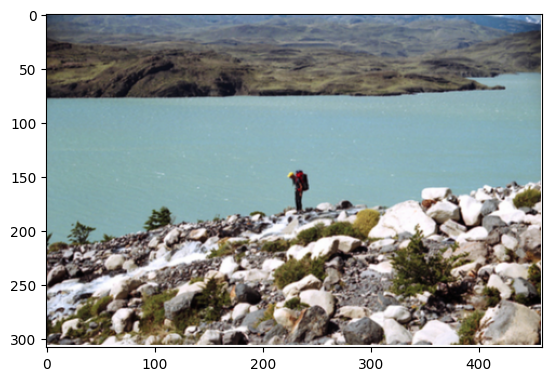

In [9]:
max_length = 32
import matplotlib.pyplot as plt


img_path = "./t3.png"

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

tokenizer = load(open("tokenizer.p","rb"))
model1 = tf.keras.models.load_model('models/model.keras')
xception_model = tf.keras.applications.xception.Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model1, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)